In [5]:
from operator import imod
import os
import numpy as np
import cv2
from data_structure import graph, node
from scipy.optimize import least_squares
from tqdm import tqdm
from matplotlib import pyplot as plt

In [63]:
class VisualOdometry():
    def __init__(self, data_dir):
        self.K_l, self.P_l, self.K_r, self.P_r = self._load_calib(os.path.join(data_dir, 'calib.txt'))
        self.gt_poses = self._load_poses(os.path.join(data_dir, 'poses.txt'))
        self.images_l = self._load_images(os.path.join(data_dir, 'image_l'))
        self.images_r = self._load_images(os.path.join(data_dir, 'image_r'))

        block = 11
        P1 = block * block * 8
        P2 = block * block * 32
        self.disparity = cv2.StereoSGBM_create(minDisparity=0, numDisparities=32, blockSize=block, P1=P1, P2=P2)
        self.disparities = [
            np.divide(self.disparity.compute(self.images_l[0], self.images_r[0]).astype(np.float32), 16)]
        self.fastFeatures = cv2.FastFeatureDetector_create()

        self.lk_params = dict(winSize=(15, 15),
                              flags=cv2.MOTION_AFFINE,
                              maxLevel=3,
                              criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 50, 0.03))
        self.points3D = []
        self.points2D = []
        self.camIndex = 0
        self.keypoints_to_follow = [], []
        self.data = []

    @staticmethod 
    def _load_calib(filepath):
        with open(filepath, 'r') as f:
            params = np.fromstring(f.readline(), dtype=np.float64, sep=' ')
            P_l = np.reshape(params, (3, 4))
            K_l = P_l[0:3, 0:3]
            params = np.fromstring(f.readline(), dtype=np.float64, sep=' ')
            P_r = np.reshape(params, (3, 4))
            K_r = P_r[0:3, 0:3]
        return K_l, P_l, K_r, P_r

    @staticmethod 
    def _load_poses(filepath):
        poses = []
        with open(filepath, 'r') as f:
            for line in f.readlines():
                T = np.fromstring(line, dtype=np.float64, sep=' ')
                T = T.reshape(3, 4)
                T = np.vstack((T, [0, 0, 0, 1]))
                poses.append(T)
        return poses

    
    @staticmethod 
    def _load_images(filepath):
        image_paths = [os.path.join(filepath, file) for file in sorted(os.listdir(filepath))]
        images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in image_paths]
        return images

    @staticmethod
    def _form_transf(R, t):
        T = np.eye(4, dtype=np.float64)
        T[:3, :3] = R
        T[:3, 3] = t
        return T

    def reprojection_residuals(self, dof, q1, q2, Q1, Q2):
        """
        Calculate the residuals

        Parameters
        ----------
        dof (ndarray): Transformation between the two frames. First 3 elements are the rotation vector and the last 3 is the translation. Shape (6)
        q1 (ndarray): Feature points in i-1'th image. Shape (n_points, 2)
        q2 (ndarray): Feature points in i'th image. Shape (n_points, 2)
        Q1 (ndarray): 3D points seen from the i-1'th image. Shape (n_points, 3)
        Q2 (ndarray): 3D points seen from the i'th image. Shape (n_points, 3)

        Returns
        -------
        residuals (ndarray): The residuals. In shape (2 * n_points * 2)
        """
        # Get the rotation vector
        r = dof[:3]
        # Create the rotation matrix from the rotation vector
        R, _ = cv2.Rodrigues(r)
        # Get the translation vector
        t = dof[3:]
        # Create the transformation matrix from the rotation matrix and translation vector
        transf = self._form_transf(R, t)

        # Create the projection matrix for the i-1'th image and i'th image
        f_projection = np.matmul(self.P_l, transf)
        b_projection = np.matmul(self.P_l, np.linalg.inv(transf))

        # Make the 3D points homogenize
        ones = np.ones((q1.shape[0], 1))
        Q1 = np.hstack([Q1, ones])
        Q2 = np.hstack([Q2, ones])

        # Project 3D points from i'th image to i-1'th image
        q1_pred = Q2.dot(f_projection.T)
        # Un-homogenize
        q1_pred = q1_pred[:, :2].T / q1_pred[:, 2]

        # Project 3D points from i-1'th image to i'th image
        q2_pred = Q1.dot(b_projection.T)
        # Un-homogenize
        q2_pred = q2_pred[:, :2].T / q2_pred[:, 2]

        # Calculate the residuals
        residuals = np.vstack([q1_pred - q1.T, q2_pred - q2.T]).flatten()
        return residuals

    def get_tiled_keypoints(self, img, tile_h, tile_w):
        """
        Splits the image into tiles and detects the 10 best keypoints in each tile

        Parameters
        ----------
        img (ndarray): The image to find keypoints in. Shape (height, width)
        tile_h (int): The tile height
        tile_w (int): The tile width

        Returns
        -------
        kp_list (ndarray): A 1-D list of all keypoints. Shape (n_keypoints)
        """
        def get_kps(x, y):
            # Get the image tile
            impatch = img[y:y + tile_h, x:x + tile_w]

            # Detect keypoints
            keypoints = self.fastFeatures.detect(impatch)

            # Correct the coordinate for the point
            for pt in keypoints:
                pt.pt = (pt.pt[0] + x, pt.pt[1] + y)

            # Get the 10 best keypoints
            if len(keypoints) > 10:
                keypoints = sorted(keypoints, key=lambda x: -x.response)
                return keypoints[:10] # ---------------------------------------------- only one keypoint is saved at the moment
            return keypoints
        # Get the image height and width
        h, w, *_ = img.shape

        # Get the keypoints for each of the tiles
        kp_list = [get_kps(x, y) for y in range(0, h, tile_h) for x in range(0, w, tile_w)]

        # Flatten the keypoint list
        kp_list_flatten = np.concatenate(kp_list)
        return kp_list_flatten

    def track_keypoints(self, img1, img2, kp1, max_error=4):
        """
        Tracks the keypoints between frames

        Parameters
        ----------
        img1 (ndarray): i-1'th image. Shape (height, width)
        img2 (ndarray): i'th image. Shape (height, width)
        kp1 (ndarray): Keypoints in the i-1'th image. Shape (n_keypoints)
        max_error (float): The maximum acceptable error
        Returns
        -------
        trackpoints1 (ndarray): The tracked keypoints for the i-1'th image. Shape (n_keypoints_match, 2)
        trackpoints2 (ndarray): The tracked keypoints for the i'th image. Shape (n_keypoints_match, 2)
        """
        # Convert the keypoints into a vector of points and expand the dims so we can select the good ones
        trackpoints1 = np.expand_dims(cv2.KeyPoint_convert(kp1), axis=1)
    
        # Use optical flow to find tracked counterparts
        trackpoints2, st, err = cv2.calcOpticalFlowPyrLK(img1, img2, trackpoints1, None, **self.lk_params)

        # Convert the status vector to boolean so we can use it as a mask
        trackable = st.astype(bool)

        # Create a maks there selects the keypoints there was trackable and under the max error
        under_thresh = np.where(err[trackable] < max_error, True, False)

        # Use the mask to select the keypoints
        trackpoints1 = trackpoints1[trackable][under_thresh]
        trackpoints2 = np.around(trackpoints2[trackable][under_thresh])

        # Remove the keypoints there is outside the image
        h, w = img1.shape
        in_bounds = np.where(np.logical_and(trackpoints2[:, 1] < h, trackpoints2[:, 0] < w), True, False)
        trackpoints1 = trackpoints1[in_bounds]
        trackpoints2 = trackpoints2[in_bounds]
        

        
        return trackpoints1, trackpoints2

    def calculate_right_qs(self, q1, q2, disp1, disp2, min_disp=0.0, max_disp=100.0):
        """
        Calculates the right keypoints (feature points)

        Parameters
        ----------
        q1 (ndarray): Feature points in i-1'th left image. In shape (n_points, 2)
        q2 (ndarray): Feature points in i'th left image. In shape (n_points, 2)
        disp1 (ndarray): Disparity i-1'th image per. Shape (height, width)
        disp2 (ndarray): Disparity i'th image per. Shape (height, width)
        min_disp (float): The minimum disparity
        max_disp (float): The maximum disparity

        Returns
        -------
        q1_l (ndarray): Feature points in i-1'th left image. In shape (n_in_bounds, 2)
        q1_r (ndarray): Feature points in i-1'th right image. In shape (n_in_bounds, 2)
        q2_l (ndarray): Feature points in i'th left image. In shape (n_in_bounds, 2)
        q2_r (ndarray): Feature points in i'th right image. In shape (n_in_bounds, 2)
        """
        def get_idxs(q, disp):
            q_idx = q.astype(int)
            disp = disp.T[q_idx[:, 0], q_idx[:, 1]]
            return disp, np.where(np.logical_and(min_disp < disp, disp < max_disp), True, False)
        
        # Get the disparity's for the feature points and mask for min_disp & max_disp
        disp1, mask1 = get_idxs(q1, disp1)
        disp2, mask2 = get_idxs(q2, disp2)
        
        # Combine the masks 
        in_bounds = np.logical_and(mask1, mask2)
        
        # Get the feature points and disparity's there was in bounds
        q1_l, q2_l, disp1, disp2 = q1[in_bounds], q2[in_bounds], disp1[in_bounds], disp2[in_bounds]
        
        # Calculate the right feature points 
        q1_r, q2_r = np.copy(q1_l), np.copy(q2_l)
        q1_r[:, 0] -= disp1
        q2_r[:, 0] -= disp2
        
        return q1_l, q1_r, q2_l, q2_r

    def calc_3d(self, q1_l, q1_r, q2_l, q2_r):
        """
        Triangulate points from both images 
        
        Parameters
        ----------
        q1_l (ndarray): Feature points in i-1'th left image. In shape (n, 2)
        q1_r (ndarray): Feature points in i-1'th right image. In shape (n, 2)
        q2_l (ndarray): Feature points in i'th left image. In shape (n, 2)
        q2_r (ndarray): Feature points in i'th right image. In shape (n, 2)

        Returns
        -------
        Q1 (ndarray): 3D points seen from the i-1'th image. In shape (n, 3)
        Q2 (ndarray): 3D points seen from the i'th image. In shape (n, 3)
        """
        # Triangulate points from i-1'th image
        Q1 = cv2.triangulatePoints(self.P_l, self.P_r, q1_l.T, q1_r.T)
        # Un-homogenize
        Q1 = np.transpose(Q1[:3] / Q1[3])

        # Triangulate points from i'th image
        Q2 = cv2.triangulatePoints(self.P_l, self.P_r, q2_l.T, q2_r.T)
        # Un-homogenize
        Q2 = np.transpose(Q2[:3] / Q2[3])

        for i in range(len(Q2) - 1, 0, -1):
            if (Q2[i][2] > 75 or Q1[i][2] > 75):
                Q2 = np.delete(Q2, i, axis=0)
                q2_l = np.delete(q2_l,i, axis=0)
                q2_r = np.delete(q2_r,i, axis=0)
                Q1 = np.delete(Q1, i, axis=0)
                q1_l = np.delete(q1_l,i, axis=0)
                q1_r = np.delete(q1_r,i, axis=0)



        return Q1, Q2, q1_l, q1_r, q2_l, q2_r


    def estimate_pose(self, q1, q2, Q1, Q2, max_iter=100):
        """
        Estimates the transformation matrix

        Parameters
        ----------
        q1 (ndarray): Feature points in i-1'th image. Shape (n, 2)
        q2 (ndarray): Feature points in i'th image. Shape (n, 2)
        Q1 (ndarray): 3D points seen from the i-1'th image. Shape (n, 3)
        Q2 (ndarray): 3D points seen from the i'th image. Shape (n, 3)
        max_iter (int): The maximum number of iterations

        Returns
        -------
        transformation_matrix (ndarray): The transformation matrix. Shape (4,4)
        """
        early_termination_threshold = 5

        # Initialize the min_error and early_termination counter
        min_error = float('inf')
        early_termination = 0

        for _ in range(max_iter):
            # Choose 6 random feature points
            sample_idx = np.random.choice(range(q1.shape[0]), 6)
            sample_q1, sample_q2, sample_Q1, sample_Q2 = q1[sample_idx], q2[sample_idx], Q1[sample_idx], Q2[sample_idx]

            # Make the start guess
            in_guess = np.zeros(6)
            # Perform least squares optimization
            opt_res = least_squares(self.reprojection_residuals, in_guess, method='lm', max_nfev=200,
                                    args=(sample_q1, sample_q2, sample_Q1, sample_Q2))

            # Calculate the error for the optimized transformation
            error = self.reprojection_residuals(opt_res.x, q1, q2, Q1, Q2)
            error = error.reshape((Q1.shape[0] * 2, 2))
            error = np.sum(np.linalg.norm(error, axis=1))

            # Check if the error is less the the current min error. Save the result if it is
            if error < min_error:
                min_error = error
                out_pose = opt_res.x
                early_termination = 0
            else:
                early_termination += 1
            if early_termination == early_termination_threshold:
                # If we have not fund any better result in early_termination_threshold iterations
                break

        # Get the rotation vector
        r = out_pose[:3]
        # Make the rotation matrix
        R, _ = cv2.Rodrigues(r)
        # Get the translation vector
        t = out_pose[3:]
        # Make the transformation matrix
        transformation_matrix = self._form_transf(R, t)
        return transformation_matrix

    def get_pose(self, i, graph):
        """
        Calculates the transformation matrix for the i'th frame

        Parameters
        ----------
        i (int): Frame index

        Returns
        -------
        transformation_matrix (ndarray): The transformation matrix. Shape (4,4)
        """

        # Get the i-1'th image and i'th image
        img1_l, img2_l = self.images_l[i - 1:i + 1]

        # Get the tiled keypoints
        kp1_l = self.get_tiled_keypoints(img1_l, 10, 20)

        # Track the keypoints
        tp1_l, tp2_l = self.track_keypoints(img1_l, img2_l, kp1_l)
        
        # Calculate the disparitie
        self.disparities.append(np.divide(self.disparity.compute(img2_l, self.images_r[i]).astype(np.float32), 16))

        # Calculate the right keypoints
        tp1_l, tp1_r, tp2_l, tp2_r = self.calculate_right_qs(tp1_l, tp2_l, self.disparities[i - 1], self.disparities[i])

        # Calculate the 3D points
        Q1, Q2, tp1_l, tp1_r, tp2_l, tp2_r = self.calc_3d(tp1_l, tp1_r, tp2_l, tp2_r)
        
        # Estimate the transformation matrix
        transformation_matrix = self.estimate_pose(tp1_l, tp2_l, Q1, Q2)
        
        # Data saved for bundle adjustment later
        new_node = node(frameID=i, keypoints=tp1_l)
        new_node.image = img1_l
        new_node.points3D = Q2 
        new_node.set_transform(transform=transformation_matrix)
        graph.add_node(new_node)

        return transformation_matrix
    
    def plot_trajectory(self, truth_path, estimated_path):
        truth_path = np.array(truth_path)
        estimated_path = np.array(estimated_path)
        fig = plt.figure()
        # set figure size
        fig.set_size_inches(5, 20)
        # fig.set_size_inches(20, 10)
        # set axis ranges
        plt.xlim((-10, 10))
        plt.plot(truth_path[:, 0], truth_path[:, 1], label='Ground Truth')
        plt.plot(estimated_path[:, 0], estimated_path[:, 1], label='Estimated')
        plt.legend()
        plt.show()

    def plot_error(self, truth_path, estimated_path):
        truth_path = np.array(truth_path)
        estimated_path = np.array(estimated_path)
        error = np.linalg.norm(truth_path - estimated_path, axis=1)
        plt.plot(error)
        plt.show()

In [64]:
data_dir = 'KITTI_sequence_1'  # Try KITTI_sequence_2 os.path.join("kitti", '07') #
vo = VisualOdometry(data_dir)
print ("lenght of gt poses: " + str(len(vo.gt_poses)))
g = graph()

# play_trip(vo.images_l, vo.images_r)  # Comment out to not play the trip

gt_path = []
estimated_path = []
original_poses = []
new_poses = []
for i, gt_pose in enumerate(tqdm(vo.gt_poses, unit="poses")):
    if i < 1:
        cur_pose = gt_pose
        original_poses.append(cur_pose)

        # Set the first pose of the first camera
        g.current_pose = cur_pose
    else:
        transf = vo.get_pose(i, g)
        original_poses.append(transf)
        # print("\nCalculated transformation:\n " + str(transf))
        # print("\nLast pose:\n" + str(cur_pose))
        cur_pose = np.matmul(cur_pose, transf)
        original_poses.append(cur_pose)
        # print("\nPose after multiplication: \n" + str(cur_pose))
        # print("\nData to visualize:\n" + str(cur_pose[0,3]) + " " + str(cur_pose[2,3]))

    gt_path.append((gt_pose[0, 3], gt_pose[2, 3]))
    estimated_path.append((cur_pose[0, 3], cur_pose[2, 3]))
    

lenght of gt poses: 51


100%|██████████| 51/51 [00:07<00:00,  6.86poses/s]


In [65]:
gt_path = np.array(gt_path)
estimated_path = np.array(estimated_path)

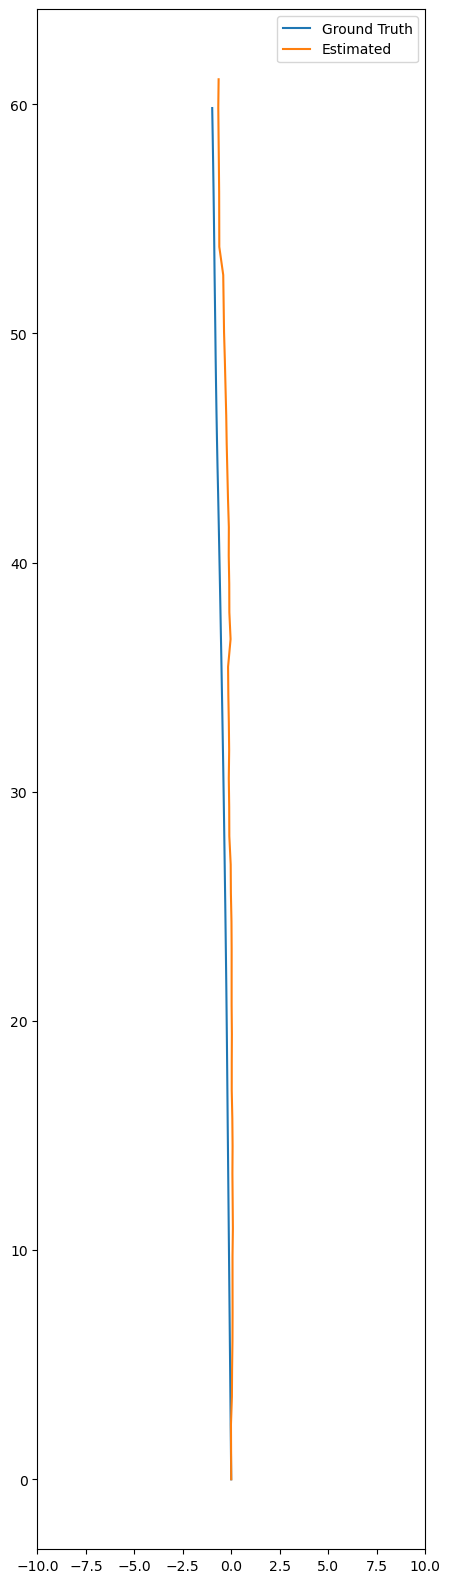

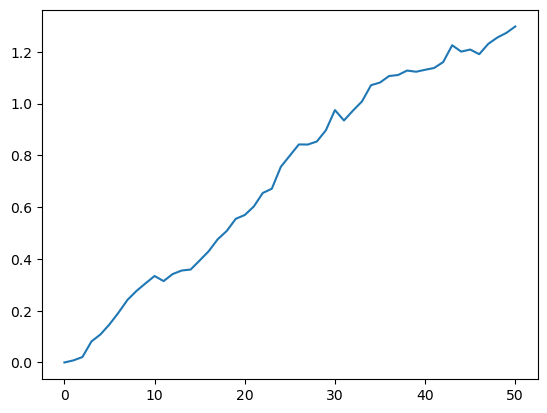

In [66]:
vo.plot_trajectory(gt_path, estimated_path)
vo.plot_error(gt_path, estimated_path)